In [5]:
# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Import for text analytics
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import wikipedia

# Text Analytics

<img src='https://images.unsplash.com/photo-1605429201125-37e867327609?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1176&q=80' width="450">

Credit: [Piotr Łaskawski](https://unsplash.com/@tot87)

## Content

The goal of this walkthrough is to provide you with insights on text analytics. [Text Analytics](https://en.wikipedia.org/wiki/Text_mining) (or text mining) is "the discovery by computer of new, previously unknown information, by automatically extracting information from different written resources." ([Marti Hearst](https://people.ischool.berkeley.edu/~hearst/text-mining.html)). Written resources may include websites, books, emails, reviews, and articles.

There are many applications of text analytics, for example:
- Search for relevant websites or articles using a search engine;
- Sentiment Analysis (e.g., classify tweets or film reviews as positive, neutral or negative);
- Summarize, anonymize, or translate documents;
- Chatbots (e.g., ChatGPT, Siri, Alexa);
- etc.

In this notebook, we will see how to prepare and represent texts and explore various text-analytics techniques, before doing an application on text similarity:
- [Text Preparation](#Text-Preparation)
    - [Tokenization](#Tokenization)
    - [Remove Stopwords](#Remove-Stopwords)
    - [Lemmatization](#Lemmatization)
    - [Your turn!](#Your-turn-Preparation)
- [Text structure](#Text-structure)
    - [Dependency Parsing](#Dependency-Parsing)
    - [Entity Detection](#Entity-Detection)
    - [Your turn!](#Your-turn-structure)
- [Text Representation](#Text-Representation)
    - [Bag of Words (BOW)](#Bag-of-Words-(BOW))
    - [TF-IDF Representation](#TF-IDF-Representation)
    - [Your turn!](#Your-turn-Representation)
- [Application: Text Similarity](#Application:-Text-Similarity)
    - [Converting text into vectors](#Converting-text-into-vectors)
    - [Cosine similarity](#Cosine-similarity)
    - [Your turn!](#Your-turn-Similarity)

## Text Preparation

In this section, we explain how to prepare a text for analysis. This includes tokenizing the text, removing stopwords, etc. 

We will use the [spaCy](https://spacy.io/) library, an open-source natural language processing library for Python. It is designed particularly for production use, and it can help us to build applications that process massive volumes of text efficiently.

You can directly [install the library](https://spacy.io/usage) in your Anaconda environment, or, if you opened this notebook in Colab, with the following line of code: 
```python
!pip install -U spacy
```

We also install the English-language model: in you Anaconda environment install "spacy-model-en_core_web_sm"; in Colab, run the following line of code: 
```python
!python -m spacy download en_core_web_sm
```

Note: If you obtain the error `Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed"`, try the following: 
```python
!pip --trusted-host github.com --trusted-host objects.githubusercontent.com install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0.tar.gz
```

Once everything is installed, and imported (at the beginning of this notebook), we can load our language dictionary, namely the English language model, using `spacy.load('en_core_web_sm')`:

In [6]:
# Load English language model
sp = spacy.load('en_core_web_sm')

### Tokenization

**Tokenization** is the process of breaking a text into pieces called tokens. A **token** simply refers to an individual part of a sentence having some semantic value. In other words, tokens are the elementary building blocks (words, numbers, characters) in a document. 

SpaCy's tokenizer takes input in form of unicode text and outputs a sequence of token objects. In addition, SpaCy automatically breaks your document into tokens when a document is created using the language model.

There are a couple of different ways we can approach this. The first is called **word tokenization**, which means breaking up the text into individual words. This is a critical step for many language processing applications, as they often require inputs in the form of individual words rather than longer strings of text.

Let’s take a look at a simple example. Imagine we have the following text, and we would like to tokenize it:

> When learning data science, you shouldn't get discouraged!

> Challenges and setbacks aren't failures, they're just part of the journey. You've got this!

We create a spaCy object, which contains linguistic annotations and various language properties:

In [7]:
# Declare text
text = """When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!"""

# spaCy object is used to create a document
my_doc = sp(text)

my_doc

When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!

In [8]:
# This is a spaCy document
type(my_doc)

spacy.tokens.doc.Doc

Let's now create a list of tokens:

In [9]:
# Create list of tokens
token_list = [token.text for token in my_doc]
token_list

['When',
 'learning',
 'data',
 'science',
 ',',
 'you',
 'should',
 "n't",
 'get',
 'discouraged',
 '!',
 '\n',
 'Challenges',
 'and',
 'setbacks',
 'are',
 "n't",
 'failures',
 ',',
 'they',
 "'re",
 'just',
 'part',
 'of',
 'the',
 'journey',
 '.',
 'You',
 "'ve",
 'got',
 'this',
 '!']

As we can see, spaCy produces a list that contains each token as a separate item. Notice that it has recognized that contractions such as _shouldn’t_ actually represent two distinct words, and has thus broken them down into two distinct tokens.

We can also see the parts-of-speech (POS) of each of these tokens using the `.pos_` attribute, as shown below.

In [10]:
# POS
for word in my_doc:
    print(word.text, '->', word.pos_)

When -> SCONJ
learning -> VERB
data -> NOUN
science -> NOUN
, -> PUNCT
you -> PRON
should -> AUX
n't -> PART
get -> AUX
discouraged -> VERB
! -> PUNCT

 -> SPACE
Challenges -> NOUN
and -> CCONJ
setbacks -> NOUN
are -> AUX
n't -> PART
failures -> NOUN
, -> PUNCT
they -> PRON
're -> AUX
just -> ADV
part -> NOUN
of -> ADP
the -> DET
journey -> NOUN
. -> PUNCT
You -> PRON
've -> AUX
got -> VERB
this -> PRON
! -> PUNCT


POS tagging can be really useful, particularly if you have words or tokens that can have multiple POS tags. For instance, the word "fish" can be used as both a noun and verb, depending upon the context:

In [11]:
# Another example
doc1 = sp("I like to fish") # verb
doc2 = sp("I eat a fish") # noun

for word in doc1:
    print(word.text, '->', word.pos_)

print("-----------------")

for word in doc2:
    print(word.text, '->', word.pos_)

I -> PRON
like -> VERB
to -> PART
fish -> VERB
-----------------
I -> PRON
eat -> VERB
a -> DET
fish -> NOUN


If we want, we can also break the text into sentences rather than words. This is called **sentence tokenization**. When performing sentence tokenization, the tokenizer looks for specific characters that normally fall between sentences, like periods, exclamation points, and newline characters.

In [12]:
# create list of sentence tokens
sents_list = [sent.text for sent in my_doc.sents]

sents_list

["When learning data science, you shouldn't get discouraged!\n",
 "Challenges and setbacks aren't failures, they're just part of the journey.",
 "You've got this!"]

### Remove Stopwords

Most text data that we work with is going to contain a lot of words that are not actually useful to our analysis (e.g., "is", "and", "you", etc.). These words, called **stopwords**, are useful in human speech, but they do not have much to contribute to the meaning of a sentence. Removing stopwords helps us eliminate noise and distraction from our text data, and also speeds up the time of the analysis (since there are fewer words to process). This makes text analysis more efficient.


Let’s take a look at the stopwords spaCy includes by default.

In [13]:
# Import stopwords from English language
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Print total number of stopwords
print('Number of stopwords: %d' % len(spacy_stopwords))

# Print 20 stopwords
print('20 stopwords: %s' % list(spacy_stopwords)[:20])

Number of stopwords: 326
20 stopwords: ['his', 'becomes', 'beforehand', 'in', 'under', 'had', 'otherwise', 'six', 'me', 'nor', 'been', 'much', 'done', 'with', 'out', 'because', 'third', 'could', 'enough', 'anything']


Now that we’ve got our list of stopwords, let’s use it to remove the stopwords from the text string we were working on in the previous section.

In [14]:
# Which words will be removed?
my_doc

When learning data science, you shouldn't get discouraged!
Challenges and setbacks aren't failures, they're just part of the journey. You've got this!

In [15]:
# Filter stopwords
filtered_sent = [word.text for word in my_doc if word.is_stop == False]

print('The filtered sentence contains the words:', filtered_sent)

The filtered sentence contains the words: ['learning', 'data', 'science', ',', 'discouraged', '!', '\n', 'Challenges', 'setbacks', 'failures', ',', 'journey', '.', 'got', '!']


We can also remove the punctuation:

In [16]:
# Filter stopwords, punctuation and spaces
filtered_sent2 = []
removed_tokens = []

for word in my_doc:
    if (word.is_stop == True) or (word.is_punct == True) or (word.is_space == True):
        removed_tokens.append(word.text)
    else:
        filtered_sent2.append(word.text)

print('We remove the following tokens:', removed_tokens)
print('The filtered sentence contains the words:', filtered_sent2)

We remove the following tokens: ['When', ',', 'you', 'should', "n't", 'get', '!', '\n', 'and', 'are', "n't", ',', 'they', "'re", 'just', 'part', 'of', 'the', '.', 'You', "'ve", 'this', '!']
The filtered sentence contains the words: ['learning', 'data', 'science', 'discouraged', 'Challenges', 'setbacks', 'failures', 'journey', 'got']


### Lemmatization

**Lemmatization** is a way of dealing with the fact that while words like connect, connection, connecting, connected, etc. are not exactly the same, they all have the same essential meaning: connect. The differences in spelling have grammatical functions in spoken language, but for machine processing, those differences can be confusing, so we need a way to change all the words that are forms of the word connect into the word connect itself.

One method for doing this is called **stemming**. Stemming involves simply lopping off easily-identified prefixes and suffixes to produce what is often the simplest version of a word, the root. Connection, for example, would have the -ion suffix removed and be reduced to connect. This kind of simple stemming is often all that is needed, but lemmatization — which actually looks at words and their roots (called lemma) as described in the dictionary — is more precise (e.g feet -> foot).

Let's look at this simple example.

In [17]:
# Lemmatization
lem = sp("run runs ran running runner runners")

# Find lemma for each word
for word in lem:
    print(word.text, '->', word.lemma_)

run -> run
runs -> run
ran -> run
running -> run
runner -> runner
runners -> runner


### Your turn! <a id = "Your-turn-Preparation"></a>

The text below is taken from the [E4S report](https://e4s.center/resources/reports/true-cost-of-food-as-a-lever-to-transform-the-swiss-food-system/) on the *True cost of food as a lever to transform the Swiss food system*.

In [49]:
text = """It is estimated that CHF 37.4 billion is spent every year on food in Switzerland. 
The estimated external costs are at least twice this amount, with health externalities weighing the most. 
Even if these costs are hidden from the market, they are incurred by our planet and societies, through e.g. public health costs and natural resources depletion.
"""

- Create two lists:
    - the first one containing the punctuation and the stopwords,
    - the second one containing the words (tokens).

In [62]:
e4s_text = sp(text)

e4s_punct_stopswords = [word.text for word in e4s_text if word.is_stop | word.is_punct | word.is_space]
display(e4s_punct_stopswords)


e4s_tokens = [word.text for word in e4s_text if not (word.is_stop | word.is_punct | word.is_space)]
display(e4s_tokens)
display(type(e4s_tokens))

['It',
 'is',
 'that',
 'is',
 'every',
 'on',
 'in',
 '.',
 '\n',
 'The',
 'are',
 'at',
 'least',
 'this',
 'amount',
 ',',
 'with',
 'the',
 'most',
 '.',
 '\n',
 'Even',
 'if',
 'these',
 'are',
 'from',
 'the',
 ',',
 'they',
 'are',
 'by',
 'our',
 'and',
 ',',
 'through',
 'and',
 '.',
 '\n']

['estimated',
 'CHF',
 '37.4',
 'billion',
 'spent',
 'year',
 'food',
 'Switzerland',
 'estimated',
 'external',
 'costs',
 'twice',
 'health',
 'externalities',
 'weighing',
 'costs',
 'hidden',
 'market',
 'incurred',
 'planet',
 'societies',
 'e.g.',
 'public',
 'health',
 'costs',
 'natural',
 'resources',
 'depletion']

list

- For each token, print its lemma

*Note:* You can convert a list of strings into a string using for instance the `join()` method

In [83]:
# Converting the e4s_tokens text tokens to sp

e4s_token_string = ' '.join(e4s_tokens)

#display(e4s_token_string)

e4s_lemmas = []

for word in sp(e4s_token_string):
    print(word.text, '->', word.lemma_)
    if word.lemma_ not in e4s_lemmas:
        e4s_lemmas.append(word.lemma_)

print(f'\nUnique lemmas: {e4s_lemmas} \nNumber of unique lemmas: {len(e4s_lemmas)}\ Number of tokens: {len(e4s_tokens)}')
print(f'\nWe removed {len(e4s_tokens)-len(e4s_lemmas)} tokens')

estimated -> estimate
CHF -> CHF
37.4 -> 37.4
billion -> billion
spent -> spend
year -> year
food -> food
Switzerland -> Switzerland
estimated -> estimate
external -> external
costs -> cost
twice -> twice
health -> health
externalities -> externality
weighing -> weigh
costs -> cost
hidden -> hidden
market -> market
incurred -> incur
planet -> planet
societies -> society
e.g. -> e.g.
public -> public
health -> health
costs -> cost
natural -> natural
resources -> resource
depletion -> depletion

Unique lemmas: ['estimate', 'CHF', '37.4', 'billion', 'spend', 'year', 'food', 'Switzerland', 'external', 'cost', 'twice', 'health', 'externality', 'weigh', 'hidden', 'market', 'incur', 'planet', 'society', 'e.g.', 'public', 'natural', 'resource', 'depletion'] 
Number of unique lemmas: 24\ Number of tokens: 28

We removed 4 tokens


## Text structure

### Dependency Parsing

**Dependency parsing** is a language processing technique that allows to better determine the meaning of a sentence by analyzing how it is constructed to determine how the individual words relate to each other.

Consider, for example, the sentence “Florence throws the ball.” We have two nouns (Florence and ball) and one verb (throws). But we cannot just look at these words individually, or we may end up thinking that the ball throws Florence! To understand the sentence correctly, we need to look at the word order and sentence structure, not just the words.

Below, we have a short sentence. We’ll use a spaCy method called `noun_chunks` ([Documentation](https://spacy.io/usage/linguistic-features#dependency-parse)), which breaks the input down into nouns and the words describing them, and iterate through each chunk in our source text, identifying the word, its root, its dependency identification, and which chunk it belongs to.

In [21]:
doc = sp("Florence threw a ball, and her friend Edoardo, in pursuit of the ball, hit a wall.")

for chunk in doc.noun_chunks:
    print(chunk.text, '-' , chunk.root.text, '-', chunk.root.dep_, '-', chunk.root.head.text)

Florence - Florence - nsubj - threw
a ball - ball - dobj - threw
her friend - friend - conj - threw
Edoardo - Edoardo - appos - friend
pursuit - pursuit - pobj - in
the ball - ball - pobj - of
a wall - wall - dobj - hit


Let's visualize this to better understand how our sentence is structured. We use a spaCy visualizer ([Documentation](https://spacy.io/usage/visualizers)):

In [22]:
# Visualization
displacy.render(doc, style="dep", jupyter= True, options={'distance': 100})

Since most of the tags are pretty abstract (and they vary between languages), you can use `spacy.explain` to get a short description of that the tag stands for:

In [23]:
tags = ['nsubj', 'dobj', 'det', 'cc', 'conj', 'poss', 'appos', 'prep', 'pobj',
       'PROPN', 'VERB', 'DET', 'NOUN', 'CCONJ', 'ADP']

@interact
def spacy_explain(dep = tags):
    return spacy.explain(dep)

interactive(children=(Dropdown(description='dep', options=('nsubj', 'dobj', 'det', 'cc', 'conj', 'poss', 'appo…

### Entity Detection

Entity detection, also called entity recognition, is a more advanced form of language processing that identifies important elements like places, people, organizations, and languages within a text. This is really helpful for quickly extracting information from the text, since you can quickly pick out important topics or identify key sections of it.

SpaCy, comes with a pre-trained classifier that detects important entities: location, time, people, money etc. To get the named entities from a document, you have to use the `ents` attribute. 

Let’s try out some entity detection using sentences about the life of [Marie Curie](https://en.wikipedia.org/wiki/Marie_Curie):

In [24]:
article = sp("""Marie Curie was a Polish and naturalized-French physicist and chemist. She was born in Warsaw in 1867 and moved to France in 1891.
She was the first person to be awarded two Nobel Prizes by the Royal Swedish Academy of Sciences: in physics in 1903 for her pioneering research on radioactivity and in chemistry in 1911 for the discovery of the elements polonium and radium.
During World War I she developed mobile radiography units to provide X-ray services to field hospitals.""")

entities = [(i, i.label_, i.label) for i in article.ents]
entities

[(Marie Curie, 'PERSON', 380),
 (Polish, 'NORP', 381),
 (French, 'NORP', 381),
 (Warsaw, 'GPE', 384),
 (1867, 'DATE', 391),
 (France, 'GPE', 384),
 (1891, 'DATE', 391),
 (first, 'ORDINAL', 396),
 (two Nobel Prizes, 'WORK_OF_ART', 388),
 (the Royal Swedish Academy of Sciences, 'ORG', 383),
 (1903, 'DATE', 391),
 (1911, 'DATE', 391),
 (World War I, 'EVENT', 387)]

The above example how spaCy is able to identify a variety of different entity types, including specific locations (GPE), date-related words (DATE), important numbers (CARDINAL), specific individuals (PERSON), etc.

Using `displaCy` we can also visualize the text, with each identified entity highlighted by a color and labeled. We’ll use `style="ent"` to tell displaCy that we want to visualize entities here.

In [25]:
displacy.render(article, style="ent", jupyter=True)

### Your turn! <a id = "Your-turn-structure"></a>

- Display the entities in the sentences below, about the life of [Elinor Ostrom](https://en.wikipedia.org/wiki/Elinor_Ostrom):

In [86]:
sentence = """Elinor Olstrom was an American political scientist and political economist born in Los Angeles. In 2009, she became the first woman to receive the Nobel Memorial Prize in Economic Sciences for her analysis of economic governance, especially the commons. 
By conducting field studies, she showed that, contrary to popular beliefs on the tragedy of the commons, natural resources that are collectively used by their users are not over-exploited and destroyed in the long-term. Instead, local communities manage shared natural resources (e.g., pastures, fishing waters, and forests) by establishing rules so that resources are used in a way that is both economically and ecologically sustainable.
Her research is described in her book "Governing the Commons: The Evolution of Institutions for Collective Action".
"""

paragraph_elionor = sp(sentence)

entities_elionor = [(i, i.label_, i.label) for i in paragraph_elionor.ents]
display(entities_elionor)

# Pretty rendered with colored highlight from the text
displacy.render(paragraph_elionor, style="ent", jupyter=True)

[(Elinor Olstrom, 'PERSON', 380),
 (American, 'NORP', 381),
 (Los Angeles, 'GPE', 384),
 (2009, 'DATE', 391),
 (first, 'ORDINAL', 396),
 (the Nobel Memorial Prize in Economic Sciences, 'WORK_OF_ART', 388),
 ("Governing the Commons: The Evolution of Institutions for Collective Action,
  'WORK_OF_ART',
  388)]

## Text Representation

The goal is to transform text into numerical features such that it can be used by ML algorithms. There are different techniques:
- **Bag of Words (BOW)** simply treat every document as an unordered set of words. It works in many case but order is not preserved. As a solution, we can use **n-grams**, i.e., we count token pairs, triplets, etc.
- **TF-IDF**: emphasizes important words, i.e., words that appear frequently in a document, (informing about the topic of the document), and words that are rare in a corpus of documents (setting one document apart from other similar ones).

To transform our text, we are going to use our old friend, the scikit learn library. As input it will require strings (and not a spaCy object). Here, our corpus of documents will consist of four sentences on [symbiosis](https://en.wikipedia.org/wiki/Symbiosis). 

In [87]:
# Sentences (as strings, not spaCy objects)
s1 = "Symbiosis is any type of a close and long-term biological interaction between two biological organisms of different species."
s2 = "Mutualism describes the ecological interaction between two or more species where each species has a net benefit."
s3 = "Commensalism is a long-term biological interaction (symbiosis) in which members of one species gain benefits while those of the other species neither benefit nor are harmed."
s4 = "Parasitism is a close relationship between species, where one organism, the parasite, lives on or inside another organism, the host, causing it some harm, and is adapted structurally to this way of life."

# List of sentences
texts = [s1, s2, s3, s4]
texts

['Symbiosis is any type of a close and long-term biological interaction between two biological organisms of different species.',
 'Mutualism describes the ecological interaction between two or more species where each species has a net benefit.',
 'Commensalism is a long-term biological interaction (symbiosis) in which members of one species gain benefits while those of the other species neither benefit nor are harmed.',
 'Parasitism is a close relationship between species, where one organism, the parasite, lives on or inside another organism, the host, causing it some harm, and is adapted structurally to this way of life.']

### Bag of Words (BOW)

We use the `CountVectorizer` class of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)), using as parameters:
- `ngram_range=(1,2)`, i.e., we consider tokens (1-grams) and pair of tokens (2-grams);
- `stop_words="english"`, a built-in stop word list for English.

In [28]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")

# Learn the vocabulary dictionary and return document-term matrix
bow = count.fit_transform(texts)

# Show feature matrix
print(bow.toarray())

[[0 0 0 0 0 0 2 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
  0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1
  0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
  0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 1 0 0 0 0 0 0 0 0 0
  0 0]
 [0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0
  0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 1 1 0 1 1 0 0
  0 0]
 [1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1
  1 1 0 0 0 0 0 0 0 0 2 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0
  1 1]]


Let's check the n-grams (tokens and pair of tokens) created:

In [29]:
# Get feature names
feature_names = count.get_feature_names_out()

# View feature names
print('Our n-grams are:', ', '.join(feature_names))

Our n-grams are: adapted, adapted structurally, benefit, benefit harmed, benefits, benefits species, biological, biological interaction, biological organisms, causing, causing harm, close, close long, close relationship, commensalism, commensalism long, describes, describes ecological, different, different species, ecological, ecological interaction, gain, gain benefits, harm, harm adapted, harmed, host, host causing, inside, inside organism, interaction, interaction biological, interaction species, interaction symbiosis, life, lives, lives inside, long, long term, members, members species, mutualism, mutualism describes, net, net benefit, organism, organism host, organism parasite, organisms, organisms different, parasite, parasite lives, parasitism, parasitism close, relationship, relationship species, species, species benefit, species gain, species net, species organism, species species, structurally, structurally way, symbiosis, symbiosis members, symbiosis type, term, term biologi

We can better visualize the result in a dataframe:

In [30]:
# Show as a dataframe
pd.set_option("display.max_columns", None)
pd.DataFrame(
    bow.todense(),              # Feature matrix
    columns=feature_names,      # n-grams
    index= ['s1', 's2', 's3', 's4']
    )

,adapted,adapted structurally,benefit,benefit harmed,benefits,benefits species,biological,biological interaction,biological organisms,causing,causing harm,close,close long,close relationship,commensalism,commensalism long,describes,describes ecological,different,different species,ecological,ecological interaction,gain,gain benefits,harm,harm adapted,harmed,host,host causing,inside,inside organism,interaction,interaction biological,interaction species,interaction symbiosis,life,lives,lives inside,long,long term,members,members species,mutualism,mutualism describes,net,net benefit,organism,organism host,organism parasite,organisms,organisms different,parasite,parasite lives,parasitism,parasitism close,relationship,relationship species,species,species benefit,species gain,species net,species organism,species species,structurally,structurally way,symbiosis,symbiosis members,symbiosis type,term,term biological,type,type close,way,way life
s1,0,0,0,0,0,0,2,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0
s2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
s3,0,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0
s4,1,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,2,1,1,0,0,1,1,1,1,1,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,1


### TF-IDF Representation

**TF-IDF** emphasizes important words. It is the product of term frequency (TF) and inverse document frequency (IDF):
- **Term Frequency** identifies tokens that appear frequently in a document: TF(token, document) = number of times token appears in document / total number of tokens in document
- **Inverse Document Frequency** identifies words that appear rarely in the corpus: IDF(token, corpus) = log( total number of documents in corpus / number of documents containing token )

Note that the IDF value for a token remains the same throughout all the documents as it depends upon the total number of documents. On the other hand, TF values of a token differ from document to document.

The goal of using TF-IDF instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus since those are less informative than tokens that occur in a small fraction of the corpus. 

Ok, let's implement TD-IDF. We are using the `TfidfVectorizer` class of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)):

In [31]:
# Using default tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words="english")

# Learn the vocabulary dictionary and return document-term matrix
features = tfidf.fit_transform(texts)

# Visualize result in dataframe
pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names_out(),
    index = ['s1', 's2', 's3', 's4']
)

,adapted,benefit,benefits,biological,causing,close,commensalism,describes,different,ecological,gain,harm,harmed,host,inside,interaction,life,lives,long,members,mutualism,net,organism,organisms,parasite,parasitism,relationship,species,structurally,symbiosis,term,type,way
s1,0.000000,0.000000,0.000000,0.536059,0.000000,0.268030,0.000000,0.000000,0.339962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.216993,0.000000,0.000000,0.268030,0.000000,0.000000,0.000000,0.000000,0.339962,0.000000,0.000000,0.000000,0.177406,0.000000,0.268030,0.268030,0.339962,0.000000
s2,0.000000,0.318741,0.000000,0.000000,0.000000,0.000000,0.000000,0.404283,0.000000,0.404283,0.000000,0.000000,0.000000,0.000000,0.000000,0.258049,0.000000,0.000000,0.000000,0.000000,0.404283,0.404283,0.000000,0.000000,0.000000,0.000000,0.000000,0.421943,0.000000,0.000000,0.000000,0.000000,0.000000
s3,0.000000,0.254397,0.322671,0.254397,0.000000,0.000000,0.322671,0.000000,0.000000,0.000000,0.322671,0.000000,0.322671,0.000000,0.000000,0.205956,0.000000,0.000000,0.254397,0.322671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.336766,0.000000,0.254397,0.254397,0.000000,0.000000
s4,0.243296,0.000000,0.000000,0.000000,0.243296,0.191817,0.000000,0.000000,0.000000,0.000000,0.000000,0.243296,0.000000,0.243296,0.243296,0.000000,0.243296,0.243296,0.000000,0.000000,0.000000,0.000000,0.486592,0.000000,0.243296,0.243296,0.243296,0.126962,0.243296,0.000000,0.000000,0.000000,0.243296


### Your turn! <a id = "Your-turn-Representation"></a>

- Create a TF-IDF Representation of the three sentences below using bigrams

In [32]:
# Sentences
s1 = "The linear economy, sometimes referred to as the take-make-waste economy, is a system where resources are extracted to make products that eventually end up as waste and are thrown away."
s2 = "A circular economy is a regenerative economic system that uses renewable energy and resources, reuses materials and products as long as possible, and recycles resources rather than disposing them as waste."
s3 = "A green economy is an economy that aims at reducing environmental risks and ecological scarcities, and that aims for sustainable development without degrading the environment."

In [91]:
text_list = [s1, s2, s3]

# Using default tokenizer in TfidfVectorizer
# Only bigrams range: 2,2
tfidf = TfidfVectorizer(ngram_range=(2,2), stop_words="english")

# Learn the vocabulary dictionary and return document-term matrix
features = tfidf.fit_transform(text_list)

# Visualize result in dataframe
pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names_out(),
    index = ['s1', 's2', 's3']
)



,benefit harmed,benefits species,biological interaction,biological organisms,close long,commensalism long,describes ecological,different species,ecological interaction,gain benefits,interaction biological,interaction species,interaction symbiosis,long term,members species,mutualism describes,net benefit,organisms different,species benefit,species gain,species net,species species,symbiosis members,symbiosis type,term biological,type close
s1,0.000000,0.000000,0.257322,0.338348,0.338348,0.000000,0.000000,0.338348,0.000000,0.000000,0.338348,0.000000,0.000000,0.257322,0.000000,0.000000,0.000000,0.338348,0.000000,0.000000,0.000000,0.000000,0.000000,0.338348,0.257322,0.338348
s2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377964,0.000000,0.377964,0.000000,0.000000,0.377964,0.000000,0.000000,0.000000,0.377964,0.377964,0.000000,0.000000,0.000000,0.377964,0.377964,0.000000,0.000000,0.000000,0.000000
s3,0.305207,0.305207,0.232118,0.000000,0.000000,0.305207,0.000000,0.000000,0.000000,0.305207,0.000000,0.000000,0.305207,0.232118,0.305207,0.000000,0.000000,0.000000,0.305207,0.305207,0.000000,0.000000,0.305207,0.000000,0.232118,0.000000


## Application: Text Similarity <a id = "Your-turn-Similarity"></a>

In this application, we will compute the similarity between various texts. We'll use Wikipedia articles, relying on the `wikipedia` library ([Documentation](https://pypi.org/project/wikipedia/)) to avoid doing the preprocessing, e.g., web scrapping to extract the articles. You can install the library using `pip install wikipedia`.

In [34]:
topics = ["Albert Einstein",
          "Adam Smith",
          "Alexander von Humboldt",
          "Amartya Sen",
          "Daniel Kahneman",
          "John von Neumann",
          "Joseph Stiglitz",
          "Stephen Hawking"
]

# Extract summary of articles
data_wiki = [wikipedia.summary(topics[p], sentences=20) for p in range(len(topics))]

Let's learn a bit more about [Alexander von Humboldt](https://en.wikipedia.org/wiki/Alexander_von_Humboldt):

In [35]:
data_wiki[2]

'Friedrich Wilhelm Heinrich Alexander von Humboldt (14 September 1769 – 6 May 1859) was a German polymath, geographer, naturalist, explorer, and proponent of Romantic philosophy and science. He was the younger brother of the Prussian minister, philosopher, and linguist Wilhelm von Humboldt (1767–1835). Humboldt\'s quantitative work on botanical geography laid the foundation for the field of biogeography. Humboldt\'s advocacy of long-term systematic geophysical measurement laid the foundation for modern geomagnetic and meteorological monitoring.Between 1799 and 1804, Humboldt travelled extensively in the Americas, exploring and describing them for the first time from a modern Western scientific point of view. His description of the journey was written up and published in several volumes over 21 years. Humboldt was one of the first people to propose that the lands bordering the Atlantic Ocean were once joined (South America and Africa in particular).\nHumboldt resurrected the use of the 

The "father of ecology", not bad! Ok, let's start our similarity analysis.

### Converting text into vectors

The first step is to convert our articles into numerical features. We use `CountVectorizer`, i.e., the Bag of Words technique, with tokens and pair of tokens (2-grams), and without stopwords.

In [36]:
# Using default tokenizer 
count_wiki = CountVectorizer(ngram_range=(1,2), stop_words = None)
bow_wiki = count_wiki.fit_transform(data_wiki)

### Cosine similarity

We can now compute the **cosine similarity**. We use the `cosine_similarity` module of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn.metrics.pairwise.cosine_similarity)).

In [37]:
# Compute pairwise similarities
pairwise_similarities = cosine_similarity(bow_wiki, bow_wiki)

# Visualize result in dataframe
pairwise_df = pd.DataFrame(
    pairwise_similarities,
    columns = topics,
    index = topics
)
pairwise_df

,Albert Einstein,Adam Smith,Alexander von Humboldt,Amartya Sen,Daniel Kahneman,John von Neumann,Joseph Stiglitz,Stephen Hawking
Albert Einstein,1.000000,0.586871,0.590091,0.469710,0.470895,0.624605,0.569374,0.600497
Adam Smith,0.586871,1.000000,0.637057,0.535201,0.502122,0.621983,0.589942,0.611138
Alexander von Humboldt,0.590091,0.637057,1.000000,0.534380,0.523306,0.637488,0.572505,0.588187
Amartya Sen,0.469710,0.535201,0.534380,1.000000,0.570070,0.549154,0.539351,0.547951
Daniel Kahneman,0.470895,0.502122,0.523306,0.570070,1.000000,0.555141,0.494984,0.534184
John von Neumann,0.624605,0.621983,0.637488,0.549154,0.555141,1.000000,0.575963,0.620196
Joseph Stiglitz,0.569374,0.589942,0.572505,0.539351,0.494984,0.575963,1.000000,0.578296
Stephen Hawking,0.600497,0.611138,0.588187,0.547951,0.534184,0.620196,0.578296,1.000000


Let's plot a heatmap to obtain a more visual representation:

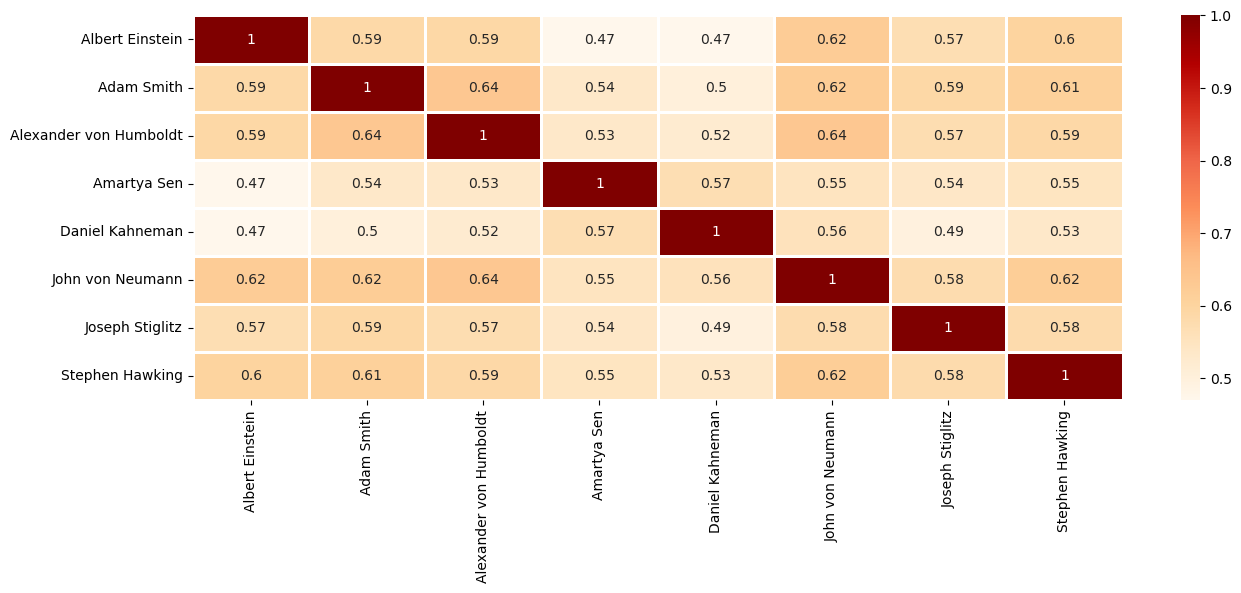

In [38]:
# Heatmap of pairwise similarities
plt.figure(figsize=(15,5))
sns.heatmap(
    pairwise_df,
    cmap='OrRd',
    linewidth=1,
    annot=True
)
plt.show()

### Your turn!

Let's continue the exploration of similarities between our articles.

- Compute a heatmap of the pairwise similarities, varying the vectorization technique (`CountVectorizer`, `TfidfVectorizer`), the ngram range, and the stopwords (e.g., `None`, "english"). How do your model compares?

*Note:* you could define a function and try interactive features.

In [39]:
# YOUR CODE HERE


- Repeat the previous operations, but this time using the full text for each Wikipedia entry. What do you observe?

In [40]:
data_full_wiki = [wikipedia.page(topics[p]).content for p in range(len(topics))]

In [41]:
# YOUR CODE HERE
